# Fake News

## Import

In [1]:
import re
import time

import nltk
import pandas as pd
from matplotlib import pyplot as plt
from nltk import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from wordcloud import WordCloud

nltk.download('punkt')  # for tokenization
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marco\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load Dataset

In [2]:
df = pd.read_csv('../american_datasets/cleaned/5.csv', index_col=0)
df.head()

title  \
0         Four ways Bob Corker skewered Donald Trump   
1  Linklater's war veteran comedy speaks to moder...   
2  Trump’s Fight With Corker Jeopardizes His Legi...   
3  Egypt's Cheiron wins tie-up with Pemex for Mex...   
4        Jason Aldean opens 'SNL' with Vegas tribute   

                                                text label  
0  Image copyright Getty Images\nOn Sunday mornin...  True  
1  LONDON (Reuters) - “Last Flag Flying”, a comed...  True  
2  The feud broke into public view last week when...  True  
3  MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...  True  
4  Country singer Jason Aldean, who was performin...  True

In [3]:
df.shape

(4009, 3)

## Visualization

(array([1872.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2137.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

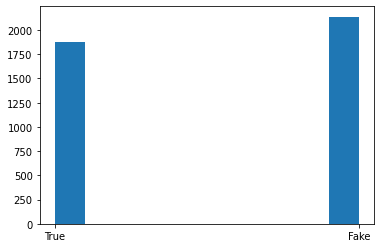

In [4]:
plt.hist(df['label'])

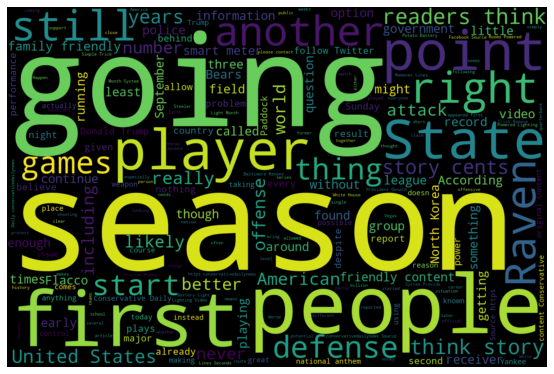

In [5]:
all_text = " ".join([str(txt) for txt in df[df['label'] == 'Fake']['text']])

wordcloud = WordCloud(min_word_length=5, width=1500, height=1000, background_color='black').generate(all_text)

fig = plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## Preprocessing

### Remove junk

In [6]:
def clean(text):
    text = str(text)
    #all lowercase
    text = text.lower()

    # remove escape sequences
    text = re.sub(r'(\r\n|\n|\r|\t)', ' ', text)

    # remove urls
    text = re.sub(
        r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', ' ',
        text)

    # remove html
    text = re.sub(r'<.*?>', ' ', text)

    # remove emoj
    text = re.sub(r"["u"\U0001F600-\U0001F64F"  # emoticons
                  u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                  u"\U0001F680-\U0001F6FF"  # transport & map symbols
                  u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                  u"\U00002702-\U000027B0"
                  u"\U000024C2-\U0001F251"
                  "]+", " ", text, flags=re.UNICODE)

    # remove all not alphanumeric character
    text = re.sub("[^a-z]+", " ", text)
    return text


df['title'] = [clean(title) for title in df['title']]
df['text'] = [clean(text) for text in df['text']]
df.head()

title  \
0         four ways bob corker skewered donald trump   
1  linklater s war veteran comedy speaks to moder...   
2  trump s fight with corker jeopardizes his legi...   
3  egypt s cheiron wins tie up with pemex for mex...   
4          jason aldean opens snl with vegas tribute   

                                                text label  
0  image copyright getty images on sunday morning...  True  
1  london reuters last flag flying a comedy drama...  True  
2  the feud broke into public view last week when...  True  
3  mexico city reuters egypt s cheiron holdings l...  True  
4  country singer jason aldean who was performing...  True

### Remove stop words

In [7]:
stop_words = set(stopwords.words("english"))


def remove_stop_words(text):
    res = []
    for word in text.split():
        if word not in stop_words:
            res.append(word)
    return " ".join(res)


df['title'] = [remove_stop_words(title) for title in df['title']]
df['text'] = [remove_stop_words(text) for text in df['text']]
df.head()

title  \
0         four ways bob corker skewered donald trump   
1  linklater war veteran comedy speaks modern ame...   
2  trump fight corker jeopardizes legislative agenda   
3  egypt cheiron wins tie pemex mexican onshore o...   
4               jason aldean opens snl vegas tribute   

                                                text label  
0  image copyright getty images sunday morning do...  True  
1  london reuters last flag flying comedy drama v...  True  
2  feud broke public view last week mr corker sai...  True  
3  mexico city reuters egypt cheiron holdings lim...  True  
4  country singer jason aldean performing las veg...  True

### Stemming

In [8]:
snowball_stemmer = SnowballStemmer(language='english')


def stemmer(text):
    res = []
    for word in text.split():
        res.append(snowball_stemmer.stem(word))
    return " ".join(res)


df['title'] = [stemmer(title) for title in df['title']]
df['text'] = [stemmer(text) for text in df['text']]
df.head()

title  \
0            four way bob corker skewer donald trump   
1  linklat war veteran comedi speak modern americ...   
2           trump fight corker jeopard legisl agenda   
3  egypt cheiron win tie pemex mexican onshor oil...   
4                  jason aldean open snl vega tribut   

                                                text label  
0  imag copyright getti imag sunday morn donald t...  True  
1  london reuter last flag fli comedi drama vietn...  True  
2  feud broke public view last week mr corker sai...  True  
3  mexico citi reuter egypt cheiron hold limit ri...  True  
4  countri singer jason aldean perform las vega s...  True

## ML Model

In [9]:
def print_metrics(y_test, y_pred, training_time):
    print('0. Training time:', round(training_time), 's')
    print('1. Accuracy:', round(accuracy_score(y_test, y_pred), 4))
    print('2. Precision:', round(precision_score(y_test, y_pred, average='macro'), 4))
    print('3. Recall:', round(recall_score(y_test, y_pred, average='macro'), 4))
    print('4. F1 score:', round(f1_score(y_test, y_pred, average='macro'), 4))
    print('5. Confusion Matrix\n\n', pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted']))

In [10]:
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [11]:
# pre processing
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
countVectorizer = CountVectorizer(min_df=2, max_df=0.7, ngram_range=(1, 2), tokenizer=token.tokenize)
tfidfTransformer = TfidfTransformer()

classifiers = [
    RandomForestClassifier(n_jobs=8),
    LogisticRegression(n_jobs=8),
    DecisionTreeClassifier(),
    AdaBoostClassifier(),
    KNeighborsClassifier(n_jobs=8)
]

#fit and prediction
for classifier in classifiers:
    start_time = time.time()
    
    print('---------------------------------')
    print(str(classifier))
    pipe = Pipeline(
        [
            ('vect', countVectorizer),
            ('tfidf', tfidfTransformer),
            ('classifier', classifier)
        ]
    )

    model = pipe.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    training_time = time.time() - start_time 
    print_metrics(y_test, y_pred, training_time)

---------------------------------
RandomForestClassifier(n_jobs=8)


0. Training time: 2 s
1. Accuracy: 0.9468
2. Precision: 0.9463
3. Recall: 0.9505
4. F1 score: 0.9466
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake        602    58
True          6   537
---------------------------------
LogisticRegression(n_jobs=8)


0. Training time: 2 s
1. Accuracy: 0.9726
2. Precision: 0.9715
3. Recall: 0.9737
4. F1 score: 0.9724
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake        635    25
True          8   535
---------------------------------
DecisionTreeClassifier()


0. Training time: 2 s
1. Accuracy: 0.9377
2. Precision: 0.9367
3. Recall: 0.9376
4. F1 score: 0.9371
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake        619    41
True         34   509
---------------------------------
AdaBoostClassifier()


0. Training time: 5 s
1. Accuracy: 0.9634
2. Precision: 0.9631
3. Recall: 0.9631
4. F1 score: 0.9631
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake        638    22
True         22   521
---------------------------------
KNeighborsClassifier(n_jobs=8)


0. Training time: 1 s
1. Accuracy: 0.936
2. Precision: 0.9346
3. Recall: 0.9376
4. F1 score: 0.9356
5. Confusion Matrix

 Predicted  Fake  True
Actual               
Fake        608    52
True         25   518
